In [17]:
# Libraries

from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Create list of all targets (minus background noise)
dataset_path = '../data_speech_commands_v0.02'
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)
target_number = len(all_targets)
print(f'Number of labels: {target_number}')  

['right', 'eight', 'cat', 'tree', 'backward', 'learn', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'follow', 'nine', 'left', 'stop', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'visual', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'forward', 'off', 'four']
Number of labels: 35


In [41]:
# Settings
feature_sets_path = '.'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'all_targets_model.h5'
wake_word = 'stop'

In [20]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [21]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = np.zeros((len(feature_sets['y_train']), len(all_targets)))
y_train[:,0] = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = np.zeros((len(feature_sets['y_val']), len(all_targets)))
y_val[:,0] = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = np.zeros((len(feature_sets['y_test']), len(all_targets)))
y_test[:,0] = feature_sets['y_test']

In [22]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(84665, 16, 16)
(10582, 16, 16)
(10582, 16, 16)
(84665, 35)
(10582, 35)
(10582, 35)


In [23]:
# Peek at labels
print(y_val)


[[27.  0.  0. ...  0.  0.  0.]
 [ 8.  0.  0. ...  0.  0.  0.]
 [ 8.  0.  0. ...  0.  0.  0.]
 ...
 [21.  0.  0. ...  0.  0.  0.]
 [16.  0.  0. ...  0.  0.  0.]
 [21.  0.  0. ...  0.  0.  0.]]


In [24]:
# Convert ground truth arrays to one wake word
for word in all_targets:
    wake_word_index = all_targets.index(word)
    print(f"{wake_word_index} = {word}")
    for i in range(len(y_train[:,0])):
        if y_train[i,0] == wake_word_index :
            y_train[i,:] = np.zeros((1, len(all_targets)))
            y_train[i,wake_word_index] = 1.0

    for i in range(len(y_val[:,0])):
        if y_val[i,0] == wake_word_index :
            y_val[i,:] = np.zeros((1, len(all_targets)))
            y_val[i,wake_word_index] = 1.0

    for i in range(len(y_test[:,0])):
        if y_test[i,0] == wake_word_index :
            y_test[i,:] = np.zeros((1, len(all_targets)))
            y_test[i,wake_word_index] = 1.0

0 = right
1 = eight
2 = cat
3 = tree
4 = backward
5 = learn
6 = bed
7 = happy
8 = go
9 = dog
10 = no
11 = wow
12 = follow
13 = nine
14 = left
15 = stop
16 = three
17 = sheila
18 = one
19 = bird
20 = zero
21 = seven
22 = up
23 = visual
24 = marvin
25 = two
26 = house
27 = down
28 = six
29 = yes
30 = on
31 = five
32 = forward
33 = off
34 = four


In [25]:
# Peek at labels after conversion
print(y_val)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [26]:
# What percentage of 'stop' appear in validation labels
print(f"Percentage of Stop : {sum(y_val[:,15]) / len(y_val[:,15])}")
print(f"Percentage of Eight : {sum(y_val[:,1]) / len(y_val[:,1])}")

Percentage of Stop : 0.03591003591003591
Percentage of Eight : 0.0722925722925723


In [27]:
# View the dimensions of our input data
print(x_train.shape)

(84665, 16, 16)


In [28]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(84665, 16, 16, 1)
(10582, 16, 16, 1)
(10582, 16, 16, 1)


In [29]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [30]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(target_number, activation='sigmoid'))

In [31]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0

In [32]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [33]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
847/847 [==============================] - 13s 13ms/step - loss: 0.1516 - acc: 0.0977 - val_loss: 0.1044 - val_acc: 0.2755
Epoch 2/30
847/847 [==============================] - 10s 12ms/step - loss: 0.1078 - acc: 0.2487 - val_loss: 0.0914 - val_acc: 0.3526
Epoch 3/30
847/847 [==============================] - 10s 12ms/step - loss: 0.0950 - acc: 0.3350 - val_loss: 0.0806 - val_acc: 0.4439
Epoch 4/30
847/847 [==============================] - 10s 12ms/step - loss: 0.0867 - acc: 0.4021 - val_loss: 0.0736 - val_acc: 0.5022
Epoch 5/30
847/847 [==============================] - 10s 12ms/step - loss: 0.0808 - acc: 0.4470 - val_loss: 0.0669 - val_acc: 0.5637
Epoch 6/30
847/847 [==============================] - 10s 12ms/step - loss: 0.0759 - acc: 0.4856 - val_loss: 0.0622 - val_acc: 0.5869
Epoch 7/30
847/847 [==============================] - 10s 12ms/step - loss: 0.0721 - acc: 0.5165 - val_loss: 0.0596 - val_acc: 0.6066
Epoch 8/30
847/847 [==============================] - 10s 12ms

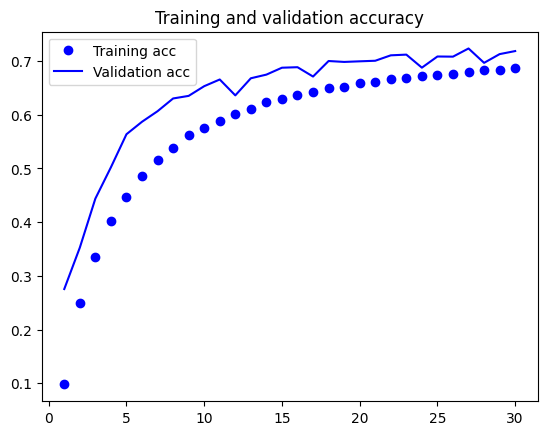

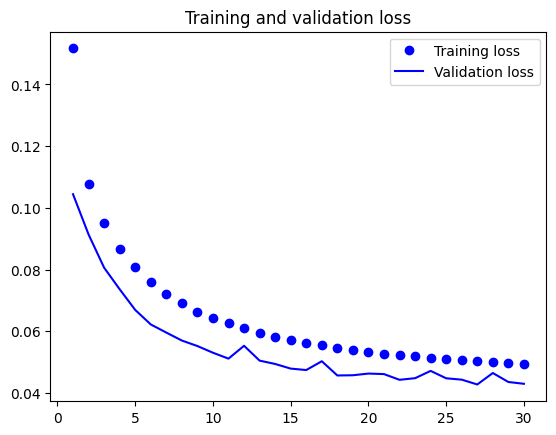

In [39]:
# Plot results


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [42]:
# Save the model as a file
models.save_model(model, model_filename)

In [45]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y[15] == 1:
        print(idx)

81
90
119
138
183
190
223
227
240
258
263
329
355
379
419
473
475
488
510
588
672
676
680
683
709
767
835
877
893
953
958
1036
1049
1070
1110
1121
1137
1140
1181
1276
1293
1341
1349
1380
1391
1398
1439
1443
1445
1466
1506
1537
1552
1573
1597
1602
1624
1653
1671
1690
1696
1724
1732
1758
1761
1777
1857
1896
1907
1933
1954
1960
1966
1989
2087
2091
2107
2145
2162
2179
2230
2245
2270
2276
2319
2387
2460
2480
2511
2605
2730
2776
2815
2831
2847
2867
2881
2885
3016
3022
3091
3100
3110
3120
3124
3169
3180
3199
3223
3246
3268
3304
3320
3321
3340
3372
3373
3410
3430
3434
3437
3440
3456
3471
3504
3525
3532
3540
3618
3631
3664
3681
3690
3706
3736
3754
3757
3826
3856
3875
3898
3952
4021
4091
4198
4314
4428
4439
4522
4550
4555
4556
4618
4634
4654
4764
4770
4785
4822
4857
4858
5052
5070
5096
5103
5120
5171
5185
5193
5197
5228
5244
5258
5286
5308
5360
5401
5439
5441
5456
5464
5471
5484
5493
5526
5549
5551
5561
5584
5612
5647
5664
5669
5703
5713
5741
5769
5777
5797
5803
5838
5884
5904
5907
5937
5942
597

In [46]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

1/1 [==============================] - 0s 88ms/step
Answer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  Prediction: [[5.88453162e-08 1.02279395e-01 3.55446218e-06 2.82254077e-05
  2.01425492e-03 1.73023529e-03 8.94164783e-04 3.08117046e-06
  1.32345567e-05 5.41237750e-06 3.26344866e-06 1.80530027e-02
  1.12379401e-03 1.54981227e-03 1.99552868e-02 5.40834990e-05
  6.17921032e-05 1.70231669e-06 3.69287699e-01 4.95565007e-04
  2.05452793e-07 2.51119382e-05 4.71056774e-05 1.78227094e-06
  9.75792948e-03 1.10861912e-07 3.43863292e-07 4.29981765e-06
  1.25558699e-05 2.96917233e-06 3.74015933e-03 4.01350930e-02
  5.34611812e-04 3.76253214e-04 7.99085479e-04]]
1/1 [==============================] - 0s 25ms/step
Answer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  Prediction: [[2.14492451e-04 6.39312377e-04 9.07613663e-04 1.29090186e-04
  7.30188331e-03 3.94339813e-03

In [47]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

331/331 [==============================] - 1s 2ms/step - loss: 0.0421 - acc: 0.7289


[0.04214106500148773, 0.7288792133331299]